In [ ]:
# Import library
import pathlib
from google.colab import drive
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [ ]:
# Download the dataset
drive.mount('/content/gdrive')
data_dir = "gdrive/My Drive/Anything about capstone/Makanan"
data_dir = pathlib.Path(data_dir)
print(data_dir)

Mounted at /content/gdrive
gdrive/My Drive/Anything about capstone/Makanan


In [ ]:
# Assign training and validation set directories
train_dir = os.path.join(data_dir, 'Training')
validation_dir = os.path.join(data_dir, 'Validation')
testing_dir = os.path.join(data_dir, 'Testing')

# Directory with training Makanan cocok untuk bayi pictures
train_cocok_dir = os.path.join(train_dir, 'Cocok untuk bayi')

# Directory with training Makanan tidak cocok untuk bayi pictures
train_tidak_dir = os.path.join(train_dir, 'Tidak cocok untuk bayi')

# Directory with validation Makanan cocok untuk bayi pictures
validation_cocok_dir = os.path.join(validation_dir, 'Cocok untuk bayi')

# Directory with validation Makanan tidak cocok untuk bayi pictures
validation_tidak_dir = os.path.join(validation_dir, 'Tidak cocok untuk bayi')

# Directory with validation Makanan cocok untuk bayi pictures
testing_cocok_dir = os.path.join(testing_dir, 'Cocok untuk bayi')

# Directory with validation Makanan tidak cocok untuk bayi pictures
testing_tidak_dir = os.path.join(testing_dir, 'Tidak cocok untuk bayi')

In [ ]:
# Checking the dataset
print('total training bahan makanan yang cocok untuk bayi:', len(os.listdir(train_cocok_dir)))
print('total training bahan makanan yang tidak cocok untuk bayi:', len(os.listdir(train_tidak_dir)))
print('total validation bahan makanan yang cocok untuk bayi:', len(os.listdir(validation_cocok_dir)))
print('total validation bahan makanan yang tidak cocok untuk bayi:', len(os.listdir(validation_tidak_dir)))
print('total testing bahan makanan yang cocok untuk bayi:', len(os.listdir(testing_cocok_dir)))
print('total testing bahan makanan yang tidak cocok untuk bayi:', len(os.listdir(testing_tidak_dir)))

cocok_files = os.listdir(train_cocok_dir)
print(cocok_files[:10])

tidak_files = os.listdir(train_tidak_dir)
print(tidak_files[:10])

total training bahan makanan yang cocok untuk bayi: 2470
total training bahan makanan yang tidak cocok untuk bayi: 2450
total validation bahan makanan yang cocok untuk bayi: 1050
total validation bahan makanan yang tidak cocok untuk bayi: 1050
total testing bahan makanan yang cocok untuk bayi: 114
total testing bahan makanan yang tidak cocok untuk bayi: 144
['300_dc5e51ca.jpg', '169_5a55a2e7.jpg', '200_f3f40ce1.jpg', '336_d8d17148.jpg', '390_1e8fb171.jpg', '368_8a274e6f.jpg', '432_2a5ce33b.jpg', '173_2104ca91.jpg', '327_00d019a3.jpg', '483_fbbce795.jpg']
['298_1803f84a.jpg', '409_6ce3c63b.jpg', '401_2e6746e7.jpg', '160_a43c3e21.jpg', '390_1ca148a7.jpg', '434_2107b149.jpg', '168_5b56ecd6.jpg', '251_3fa54840.jpg', '497_09035f67.jpg', '491_2dfda05e.jpg']


In [ ]:
# Checking the pictures in dataset
pic_index = 2

next_cocok = [os.path.join(train_cocok_dir, fname) 
                for fname in cocok_files[pic_index+2:pic_index]]
next_tidak = [os.path.join(train_tidak_dir, fname) 
                for fname in tidak_files[pic_index+2:pic_index]]

for i, img_path in enumerate(next_cocok+next_tidak):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224), 
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

testing_datagen = ImageDataGenerator(rescale=1./255)

testing_generator = testing_datagen.flow_from_directory(
        testing_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

Found 4920 images belonging to 2 classes.
Found 2100 images belonging to 2 classes.
Found 258 images belonging to 2 classes.


In [ ]:
# Using MobileNet For Model
categories = ["Bahan Makanan cocok untuk bayi", "Bahan Makanan tidak cocok untuk bayi"]

mobile_net = MobileNet(input_shape = [224,224,3], weights = 'imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Adding custom layers 
x = tf.keras.layers.Flatten()(mobile_net.output)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Last layer using softmax activation
prediction = Dense(2, activation='softmax')(x)

# Creating model
model = Model(inputs=mobile_net.input, outputs=prediction)

# Summary model
model.summary()

# Model compile
model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
# Constant for epochs
EPOCHS = 20
steps_per_epoch= 150

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose = 2,
      validation_steps=100)

Epoch 1/20
150/150 - 1236s - loss: 0.6836 - accuracy: 0.6587 - val_loss: 0.5258 - val_accuracy: 0.7620 - 1236s/epoch - 8s/step
Epoch 2/20
150/150 - 693s - loss: 0.5452 - accuracy: 0.7423 - val_loss: 0.3197 - val_accuracy: 0.8680 - 693s/epoch - 5s/step
Epoch 3/20
150/150 - 755s - loss: 0.4804 - accuracy: 0.7743 - val_loss: 0.3068 - val_accuracy: 0.8750 - 755s/epoch - 5s/step
Epoch 4/20
150/150 - 767s - loss: 0.4278 - accuracy: 0.8017 - val_loss: 0.3424 - val_accuracy: 0.8510 - 767s/epoch - 5s/step
Epoch 5/20
150/150 - 795s - loss: 0.4097 - accuracy: 0.8083 - val_loss: 0.3063 - val_accuracy: 0.8805 - 795s/epoch - 5s/step
Epoch 6/20
150/150 - 767s - loss: 0.3759 - accuracy: 0.8333 - val_loss: 0.2791 - val_accuracy: 0.8930 - 767s/epoch - 5s/step
Epoch 7/20
150/150 - 701s - loss: 0.3505 - accuracy: 0.8460 - val_loss: 0.2780 - val_accuracy: 0.8945 - 701s/epoch - 5s/step
Epoch 8/20
150/150 - 717s - loss: 0.3159 - accuracy: 0.8637 - val_loss: 0.2806 - val_accuracy: 0.8925 - 717s/epoch - 5s/ste

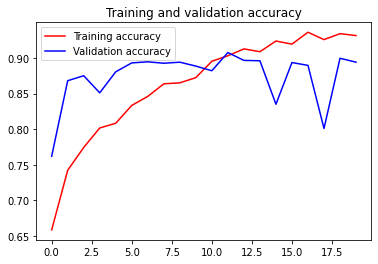

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()


# If the model overfitting accuracy for training > validation

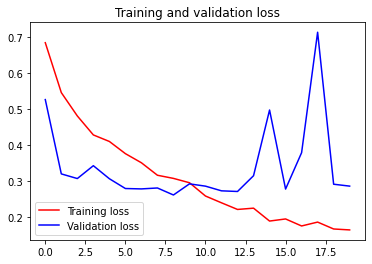

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()


# If the model overfitting loss for validation > training

Classification Report
                                           precision    recall  f1-score   support

      Bahan makanan yang cocok untuk bayi       0.88      0.91      0.90      1050
Bahan makanan yang tidak cocok untuk bayi       0.90      0.88      0.89      1050

                                 accuracy                           0.89      2100
                                macro avg       0.89      0.89      0.89      2100
                             weighted avg       0.89      0.89      0.89      2100



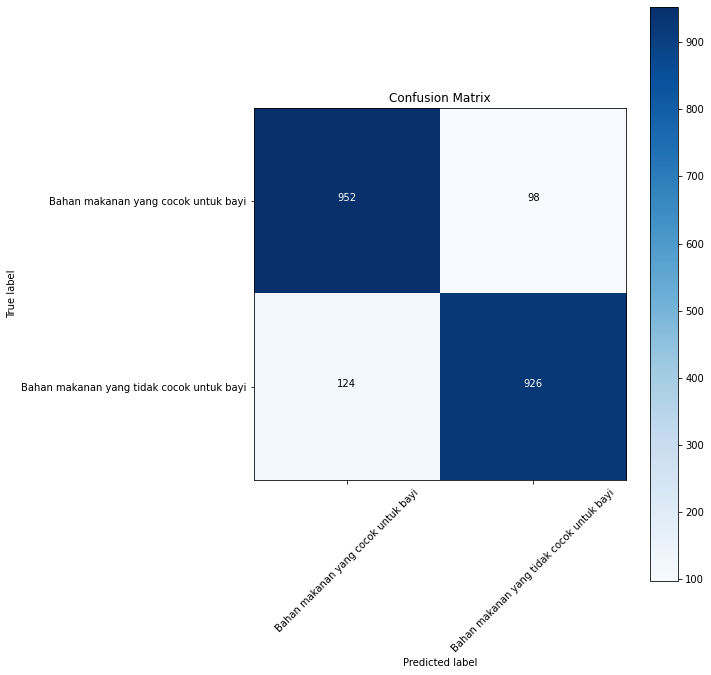

In [ ]:
# Plot the confusion matrix. Set Normalize = True/False For Data Validation
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# On test dataset
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Bahan makanan yang cocok untuk bayi', 'Bahan makanan yang tidak cocok untuk bayi']

# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Saving kangkgung - cocok.jpg to kangkgung - cocok.jpg
kangkgung - cocok.jpg
[9.9999630e-01 3.7290142e-06]


Bahan Makanan cocok untuk bayi


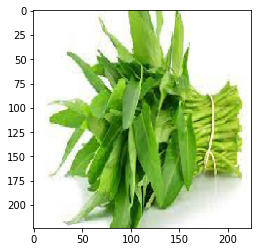

In [ ]:
## Test image with new data
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediction
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  # x = image.img_to_array(img)
  x = np.expand_dims(img, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  print(classes[0])

  print("\n")

  if classes[0][0] > classes[0][1] :
    print('Bahan Makanan cocok untuk bayi')
  else :
    print('Bahan Makanan tidak cocok untuk bayi')

Classification Report
                                           precision    recall  f1-score   support

      Bahan makanan yang cocok untuk bayi       0.89      0.96      0.92       114
Bahan makanan yang tidak cocok untuk bayi       0.97      0.90      0.94       144

                                 accuracy                           0.93       258
                                macro avg       0.93      0.93      0.93       258
                             weighted avg       0.93      0.93      0.93       258



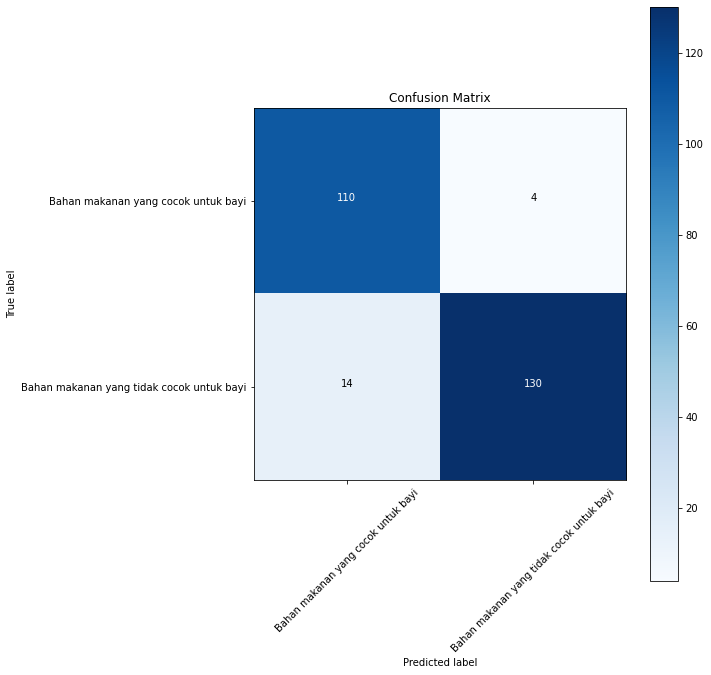

In [ ]:
# Plot the confusion matrix for Data Testing

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# On test dataset
Y_pred = model.predict(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Bahan makanan yang cocok untuk bayi', 'Bahan makanan yang tidak cocok untuk bayi']

# Confusion Matrix
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

In [ ]:
## RUN WEBCAM

# load model
model = load_model('my_model.model')

# open webcam
webcam = cv2.VideoCapture(0)
    
classes = ['Bahan makanan yang cocok untuk bayi','Bahan makanan yang tidak cocok untuk bayi']

# loop through frames
while webcam.isOpened():

    # read frame from webcam 
    status, frame = webcam.read()

    # apply face detection
    face, confidence = cv.detect_face(frame)


    # loop through detected faces
    for idx, f in enumerate(face):

        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
webcam.release()
cv2.destroyAllWindows()


In [ ]:
from google.colab import files
model.save('my_model')

!zip -r /content/my_model.zip /content/my_model 
files.download('/content/my_model.zip')

INFO:tensorflow:Assets written to: my_model/assets
  adding: content/my_model/ (stored 0%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: content/my_model/variables/variables.index (deflated 79%)
  adding: content/my_model/keras_metadata.pb (deflated 95%)
  adding: content/my_model/saved_model.pb (deflated 91%)
  adding: content/my_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('my_model.h5')